In [25]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools
from __future__ import division
from sklearn.tree import tree, DecisionTreeClassifier, export_graphviz
from sklearn import cluster
import math
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("max_rows", 500)

In [26]:
filePath = 'datasets/NYPD_Motor_Vehicle_Collisions_weather4.csv'
colls = pd.read_csv(filePath)

print len(colls.index)

colls = colls[pd.notnull(colls['LOCATION'])]


769054


C:\Users\Casper\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
colls['LATITUDE'] = colls.LOCATION.str.split(',').str.get(0).str.split('(').str.get(1).astype('float64')
colls['LONGITUDE'] = colls.LOCATION.str.split(',').str.get(1).str.split(')').str.get(0).astype('float64')

In [28]:
 condition = 'Fog'

In [29]:
X = colls[colls.Conditions == condition][['LATITUDE','LONGITUDE']].values

In [30]:
eps = 0.0012

core_point_size =  5


##############################################################################
# Compute DBSCAN
db = DBSCAN(eps=eps, min_samples=core_point_size).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 14


C:\Users\Casper\Anaconda2\lib\site-packages\matplotlib\lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


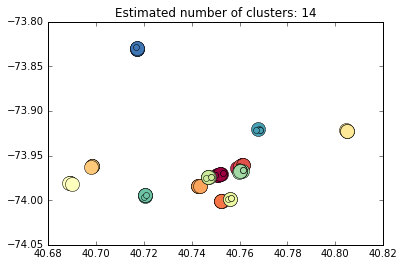

In [31]:
# Plot result


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        continue
        ##col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [32]:
import geoplotlib as gpl

df = pd.DataFrame(X, columns=['LATITUDE', 'LONGITUDE'])
df['Cluster'] = db.labels_

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [[int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16), 255] for i in colors]

colormap = get_spaced_colors(n_clusters_)

# Plot noise? Plot cluster -1
#lat,lon = coords(-1)
#latlong = {'lon': lon, 'lat': lat}
#gpl.dot(latlong, color='w')

def coords(k):
    lat = df[df['Cluster'] == k].LATITUDE.values
    lon = df[df['Cluster'] == k].LONGITUDE.values
    
    return lat,lon
    
for i in range(0, n_clusters_):
    lat, lon = coords(i)

    latlong = {'lon': lon, 'lat': lat}
    gpl.dot(latlong, color=colormap[i])
    

gpl.inline()

In [33]:
df[df.Cluster >= 0].to_csv('datasets/dbscan/'+condition+'.csv', sep=',')

## Prepare the data to be visualized on the webpage

In [ ]:
r = 'datasets/dbscan/'

paths = [r+'Fog.csv', r+'Heavy Rain.csv', r+'Rain.csv', r+'Snow.csv']

clusters = {}
for p in paths:
    print p.split('/')[-1].split('.')[0]
    clusters[p.split('/')[-1].split('.')[0]] = pd.DataFrame.from_csv(p)

In [ ]:
clusterRoot = {'name':'clusters','children': [], 'type': 'root'}

for condition,dataframe in clusters.iteritems():
    aChild = {'name': condition, 'children': [], 'type': 'condition'}
    for aCluster in dataframe.Cluster.unique():
        aClusterChild = {'name': str(aCluster), 'children': [], 'intensity': len(dataframe[dataframe.Cluster == aCluster]), 'type': 'cluster'}
        dataframe['LOCATION'] = dataframe.LATITUDE.astype('str').str.cat(dataframe.LONGITUDE.astype('str'),sep=',')
        for point in dataframe[(dataframe.Cluster == aCluster)].LOCATION.unique():
            ins = len(dataframe[dataframe.LOCATION == point])
            aClusterChild['children'].append({'name': point, 'intensity': ins, 'type': 'intersection'})
        aChild['children'].append(aClusterChild)
    clusterRoot['children'].append(aChild)
    
    
clusterRoot

In [ ]:
import json
with open('datasets/dbscan/clusters.json', 'w') as fp:
    json.dump(clusterRoot, fp)